<a href="https://colab.research.google.com/github/chw8207/fastai_pytorch/blob/main/%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### GPU 설정

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10157932349162492272
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40129593344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 109449157162664903
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


### 데이터 : 무비렌즈

In [4]:
path = untar_data(URLs.ML_100k)

In [5]:
# 해당 테이블을 열고 내용을 살펴보기
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestap'])
ratings.head()

,user,movie,rating,timestap
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
# SF, 액션, 고전 영화를 나타내는 요소(스타워즈 최신작)
rise_skywalker = np.array([0.98,0.9,-0.9])

In [7]:
# 현대적인 SF영화를 좋아하는 사용자
user1 = np.array([0.9,0.8,-0.6])

In [8]:
# 이 둘의 조합에서 유사성 계산
(user1*rise_skywalker).sum()

2.1420000000000003

In [9]:
# 영화 카사블랑카
casablanca = np.array([-0.99,-0.3,0.8])

In [10]:
# 사용자 조합해서 유사성 계산
(user1*casablanca).sum()

-1.611

### DataLoaers만들기

In [11]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
# ratings와 결합하기
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestap,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [13]:
# CollabDataLoader()객체 구축
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,349,Trainspotting (1996),4
1,455,Love! Valour! Compassion! (1997),4
2,178,"Sound of Music, The (1965)",4
3,881,Balto (1995),3
4,831,Spawn (1997),2
5,184,"Piano, The (1993)",4
6,344,Four Weddings and a Funeral (1994),3
7,207,Private Parts (1997),3
8,130,Mortal Kombat (1995),3
9,709,"Basketball Diaries, The (1995)",5


In [14]:
# 영화와 사용자의 잠재 요소 테이블을 간단한 행렬로 표현하기
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

In [15]:
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [16]:
# 색인 3을 표현하는 원핫 인코딩된 벡터에
# 사용자용 잠재 요소 행렬을 곱함.
one_hot_3 = one_hot(3, n_users).float()
user_factors.t()@one_hot_3

tensor([ 0.7358,  0.6173,  0.2240, -1.7101,  2.0847])

In [17]:
# 행렬의 세 번째 색인에 해당되는 벡터
user_factors[3]

tensor([ 0.7358,  0.6173,  0.2240, -1.7101,  2.0847])

### 밑바닥부터 만드는 협업 필터링

In [18]:
# 클래스 만들어보기
class Example :
  def __init__(self, a) :
    self.a = a
  def say(self, x) :
    return f'Hello {self.a}, {x}'

In [19]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you'

In [20]:
# 점곱 계산하는 모델
class DotProduct(Module) :
  def __init__(self, n_users, n_movies, n_factors) :
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self, x) :
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users*movies).sum(dim=1)

In [21]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [22]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [23]:
# 모델 학습
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.342552,1.250540,00:07
1,1.073260,1.063444,00:07
2,0.931124,0.957575,00:07
3,0.787626,0.877493,00:07
4,0.764942,0.860615,00:07


In [24]:
# 모델 개선 : 예측 범위 강제(0~5.5)
class DotProduct(Module) :
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)) :
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self, x) :
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users*movies).sum(dim=1), *self.y_range)

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.001288,0.976757,00:07
1,0.877999,0.892996,00:07
2,0.666592,0.855430,00:07
3,0.475114,0.860085,00:07
4,0.369927,0.865007,00:07


In [25]:
# 모델 수정하기(편향도 고려)
class DotProduct(Module) :
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)) :
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x) :
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users*movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.964292,0.939328,00:07
1,0.820949,0.852057,00:07
2,0.601662,0.852411,00:07
3,0.410741,0.875781,00:08
4,0.292748,0.882678,00:07


#### 가중치 감쇠(L2정규화)

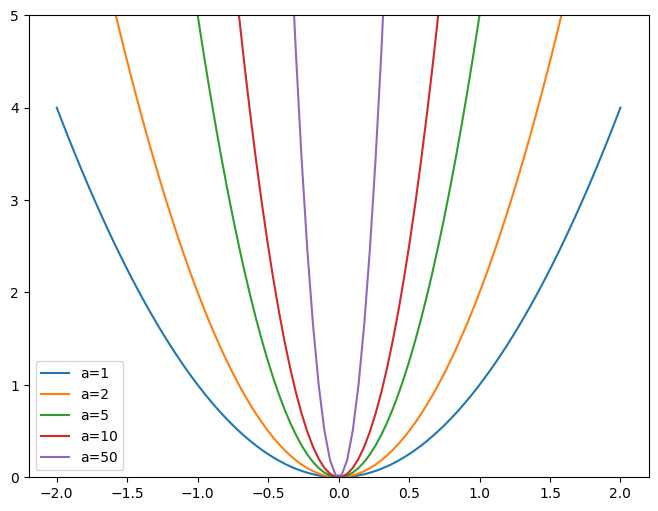

In [26]:
# 그래프 예시
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50]
ys = [a*x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s, ys) :
  ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend()
plt.show();

In [27]:
# 가중치 감쇠 : wd 사용
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.953552,0.942304,00:07
1,0.874909,0.876468,00:07
2,0.734998,0.824178,00:07
3,0.599158,0.809704,00:07
4,0.508671,0.811296,00:08


#### 나만의 임베딩 모듈

In [29]:
class T(Module) :
  def __init(self) :
    self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [30]:
# nn.Parameter 클래스로 래핑하기
class T(Module) :
  def __init__(self) :
    self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [31]:
class T(Module) :
  def __init__(self) :
    self.a = nn.Linear(1,3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[0.4698],
        [0.2860],
        [0.0590]], requires_grad=True)]

In [34]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [35]:
# 명시적으로 임의 초기화된 텐서를 파라미터로 생성하기
def create_params(size) :
  return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [38]:
# 이를 이용하여 DotProductBias 만들어보기
class DotProductBias(Module) :
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)) :
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x) :
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users*movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

In [39]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.943919,0.929071,00:08
1,0.847113,0.863549,00:08
2,0.746327,0.820706,00:08
3,0.583917,0.809650,00:08
4,0.469677,0.810395,00:08


### 임베딩과 편향의 분석